In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\core\framework\resource_handle_pb2.py:23: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  serialized_pb=_b('\n/tensorflow/core/framework/resource_handle.proto\x12\ntensorflow\"r\n\x13ResourceHandleProto\x12\x0e\n\x06\x64\x65vice\x18\x01 \x01(\t\x12\x11\n\tcontainer\x18\x02 \x01(\t\x12\x0c\n\x04name\x18\x03 \x01(\t\x12\x11\n\thash_code\x18\x04 \x01(\x04\x12\x17\n\x0fmaybe_type_name\x18\x05 \x01(\tBn\n\x18org.tensorflow.frameworkB\x0eResourceHandleP\x01Z=github.com/tensorflow/tensorflow/tensorflow/go/core/fram

C:\Users\samsung\gridworld.py:118: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  b = scipy.misc.imresize(a[:,:,0],[84,84,1],interp='nearest')
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\scipy\misc\pilutil.py:555: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, mode=mode)
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\scipy\misc\pilutil.py:337: DeprecationWarning:     `bytescale` is deprecated!
    `bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  cmin=cmin, cmax=cmax)
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\scipy\misc\pilutil.py:338: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  image = Im

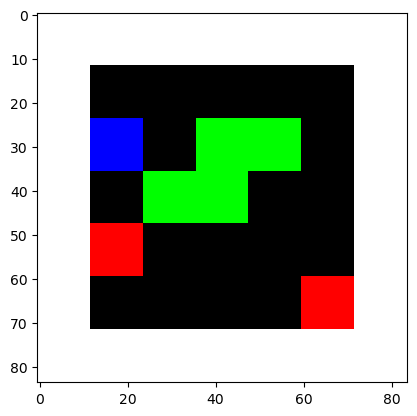

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

About implementing network

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

experience replay

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [5]:
def processState(states):
    return np.reshape(states,[21168])

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

Training the network

In [7]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\framework\tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


Instructions for updating:
Use keras.layers.flatten instead.



C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\framework\tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\framework\tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


C:\Users\samsung\gridworld.py:118: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  b = scipy.misc.imresize(a[:,:,0],[84,84,1],interp='nearest')
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\scipy\misc\pilutil.py:555: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, mode=mode)
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\scipy\misc\pilutil.py:337: DeprecationWarning:     `bytescale` is deprecated!
    `bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  cmin=cmin, cmax=cmax)
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\scipy\misc\pilutil.py:338: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  image = Im

Saved Model
500 3.0 1
1000 3.3 1
1500 2.2 1
2000 2.1 1
2500 0.2 1
3000 2.9 1
3500 1.3 1
4000 1.6 1
4500 2.1 1
5000 1.7 1
5500 2.4 1
6000 2.9 1
6500 1.2 1
7000 1.3 1
7500 2.3 1
8000 2.3 1
8500 1.4 1
9000 3.1 1
9500 0.2 1
10000 2.7 1
10500 2.0 0.9549999999999828
11000 2.2 0.9099999999999655
11500 1.5 0.8649999999999483
12000 1.2 0.819999999999931
12500 2.2 0.7749999999999138
13000 2.5 0.7299999999998965
13500 1.2 0.6849999999998793
14000 1.8 0.639999999999862
14500 1.7 0.5949999999998448
15000 1.3 0.5499999999998275
15500 2.7 0.5049999999998103
16000 1.8 0.4599999999998177
16500 2.9 0.41499999999982823
17000 2.2 0.36999999999983874
17500 2.9 0.32499999999984924
18000 1.8 0.27999999999985975
18500 3.0 0.23499999999986562
19000 2.8 0.18999999999986225
19500 2.0 0.14499999999985888
20000 3.9 0.09999999999985551
20500 2.8 0.09999999999985551
21000 2.4 0.09999999999985551
21500 4.1 0.09999999999985551
22000 2.4 0.09999999999985551
22500 1.7 0.09999999999985551
23000 2.3 0.09999999999985551
23

KeyboardInterrupt: 

시각화

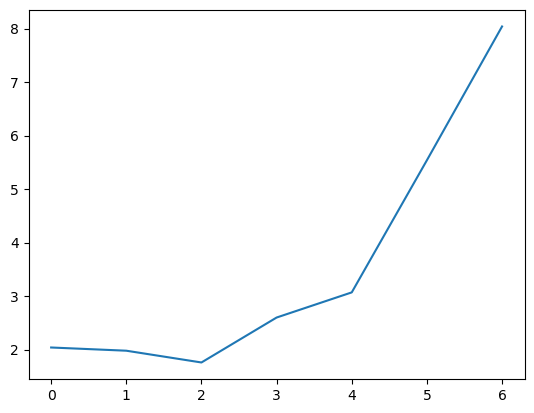

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)